# `StableSpectralElements.jl` - 2D Euler vortex example using entropy-stable modal discretization

First, let's load the packages used in this example.

In [47]:
using StableSpectralElements, OrdinaryDiffEq
using Plots, Plots.PlotMeasures, TimerOutputs

We will be solving the two-dimensional compressible Euler equations, which are a hyperbolic system of conservation laws given by
$$
\begin{aligned}
\partial_t \rho(\boldsymbol{x},t) + \nabla_{\boldsymbol{x}} \cdot ( \rho(\boldsymbol{x},t) \boldsymbol{V}(\boldsymbol{x},t)) &= 0,\\
\partial_t ( \rho(\boldsymbol{x},t) \boldsymbol{V}(\boldsymbol{x},t)) + \nabla_{\boldsymbol{x}} \cdot ( \rho(\boldsymbol{x},t) \boldsymbol{V}(\boldsymbol{x},t) \otimes \boldsymbol{V}(\boldsymbol{x},t) + P(\boldsymbol{x},t)\boldsymbol{I}) &= \boldsymbol{0},\\
\partial_t E(\boldsymbol{x},t) + \nabla_{\boldsymbol{x}} \cdot ((E(\boldsymbol{x},t) + P(\boldsymbol{x},t))\boldsymbol{V}(\boldsymbol{x},t)) &= 0,
\end{aligned}
$$
with 
$$
 P(\boldsymbol{x},t) = (\gamma - 1)\big(E(\boldsymbol{x},t) - \tfrac{1}{2} \rho(\boldsymbol{x},t) \lVert \boldsymbol{V}(\boldsymbol{x},t) \rVert^2 \big),
$$
where $\gamma = 1.4$ is the specific heat ratio. The initial condition is an isentropic vortex in a uniform flow on the domain $\Omega = (0,1)^2$ with periodic boundary conditions, at a  Mach number of 0.4. The density field is shown below.

![620x400](euler_initial_condition.png)

In [48]:
mach_number = 0.4
angle = 0.0
L = 1.0
γ=1.4
T = L/mach_number # end time
strength = sqrt(2/(γ-1)*(1-0.75^(γ-1))) # for central value of ρ=0.75

conservation_law = EulerEquations{2}(γ)
exact_solution = IsentropicVortex(conservation_law, θ=angle,
    Ma=mach_number, β=strength, R=1.0/10.0, x_0=(L/2,L/2));

Let's discretize the above problem using a `ModalMultiDiagE` discretization of degree $p = 3$ on an isoparametrically warped triangular mesh with $M = 4$ edges in each direction. We will use an entropy-stable flux-differencing scheme employing [Ranocha's two-point flux](https://link.springer.com/chapter/10.1007/978-3-030-39647-3_42) and Lax-Friedrichs interface dissipation; to obtain an entropy-conservative scheme, one can instead take `inviscid_numerical_flux=EntropyConservativeNumericalFlux()`. The modal (i.e. non-collocated) formulation necessitates the introduction of an "entropy projection" procedure introduced by [Chan (2018)](https://arxiv.org/abs/1708.01243).

In [49]:
p = 3
M = 4

form = FluxDifferencingForm(inviscid_numerical_flux=EntropyConservativeNumericalFlux(),
    entropy_projection=true)

reference_approximation = ReferenceApproximation(ModalMultiDiagE(p), 
    Tri(), mapping_degree=p, N_plot=25)

uniform_mesh = uniform_periodic_mesh(reference_approximation, ((0.0,L),(0.0,L)), (M,M))

mesh = warp_mesh(uniform_mesh, reference_approximation, ChanWarping(1/16, (L,L)))

spatial_discretization = SpatialDiscretization(mesh, reference_approximation)

results_path = save_project(conservation_law,
     spatial_discretization, exact_solution, form, (0.0, T),
    "results/euler_vortex_2d/", overwrite=true, clear=true);

ode = semidiscretize(conservation_law, spatial_discretization, 
    exact_solution, form, (0.0, T), ReferenceOperator(),
    mass_matrix_solver=CholeskySolver(spatial_discretization));

We'll now plot the mesh, showing the tensor-product quadrature nodes.

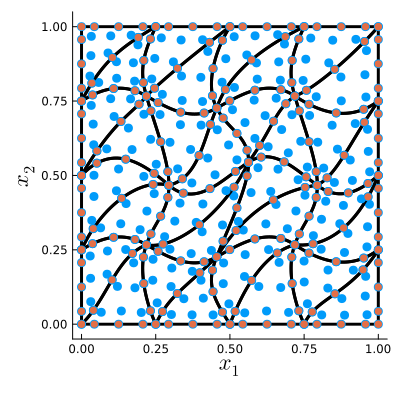

In [50]:
plot(spatial_discretization, grid_connect=true, fmt=:png)

The resulting system of ordinary differential equations can then be solved as usual using OrdinaryDiffEq.jl's `solve` function.

In [51]:
dt = T/1000
reset_timer!()
sol = solve(ode, CarpenterKennedy2N54(), dt=dt, adaptive=false,
        save_everystep=false, callback=save_callback(results_path, (0.0,T),  
        floor(Int, T/(dt*50))))
print_timer()

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            8.20s /  99.4%           8.88GiB / 100.0%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 du/dt                  5.05k    8.15s  100.0%  1.61ms   8.87GiB  100.0%  1.80MiB
   eval residual        5.05k    4.56s   55.9%   903μs   4.95GiB   55.7%  1.00MiB
   reconstruct noda...  5.05k    3.59s   44.0%   711μs   3.93GiB   44.3%   815KiB
 ────────────────────────────────────────────────────────────────────────────────


The $L^2$ error in each conservative variable (i.e. $\rho$, $\rho V_1$, $\rho V_2$, and $E$) can be computed as follows.

In [52]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), exact_solution, T))

L2 error:
[0.027954049350458362, 0.06348081075345663, 0.05546371956547186, 0.060874070799289914]


We'll check that the scheme is indeed conservative by plotting the evolution of the integrated conservative variables.

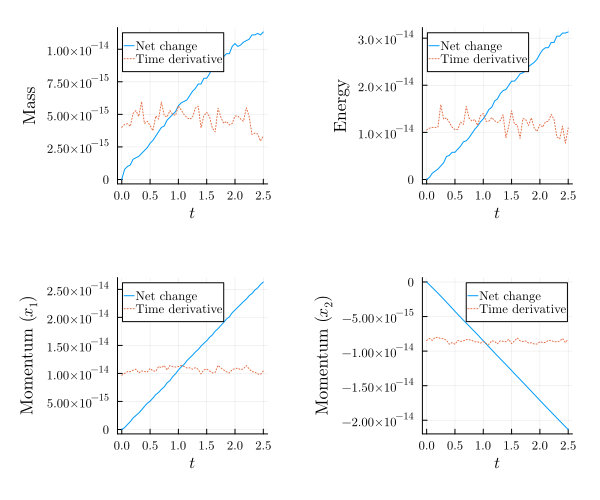

In [53]:
conservation = analyze(PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization),
    load_time_steps(results_path))

mass = plot(conservation, ylabel="Mass", 1)
xmom = plot(conservation, ylabel="Momentum (\$x_1\$)", 2)
ymom = plot(conservation, ylabel="Momentum (\$x_2\$)", 3)
energy = plot(conservation, ylabel="Energy", 4)

plot(mass, energy, xmom, ymom, size=(600,500), margin=5mm, fmt=:png)

We can finally plot the evolution of the integrated mathematical entropy $\int_{\Omega} S(U(\boldsymbol{x},t)) \, \mathrm{d} \boldsymbol{x}$, where $S(U(\boldsymbol{x},t)) = - \tfrac{1}{1-\gamma}\rho(\boldsymbol{x},t) \ln(p(\boldsymbol{x},t)/\rho(\boldsymbol{x},t)^\gamma) $, again using the scheme's collocated LGL quadrature rule. Notice that the semi-discrete scheme dissipates entropy, as expected.

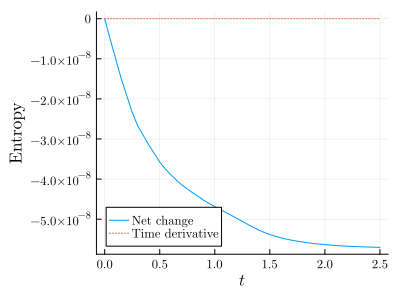

In [54]:
entropy_analysis = EntropyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization, CholeskySolver(spatial_discretization))
entropy_results = analyze(entropy_analysis, load_time_steps(results_path))
entropy = plot(entropy_results, ylabel="Entropy", size=(400,300), fmt=:png)

We can now visualize the density field as a `.vtu` file, for example, in ParaView.

In [55]:
for i in eachindex(sol.u)
    postprocess_vtk(spatial_discretization, string(results_path,
        "solution_",i,".vtu"), sol.u[i], variable_name="Density")
end

┌ Error: Error watching manifest
│   exception =
│    SystemError: opening file "/Users/tristanmontoya/.julia/packages/StartUpDG/bzFU4/src/StartUpDG.jl__@require__": No such file or directory
│    Stacktrace:
│     [1] systemerror(p::String, errno::Int32; extrainfo::Nothing)
│       @ Base ./error.jl:176
│     [2] #systemerror#82
│       @ ./error.jl:175 [inlined]
│     [3] systemerror
│       @ ./error.jl:175 [inlined]
│     [4] open(fname::String; lock::Bool, read::Nothing, write::Nothing, create::Nothing, truncate::Nothing, append::Nothing)
│       @ Base ./iostream.jl:293
│     [5] open
│       @ ./iostream.jl:275 [inlined]
│     [6] #open#409
│       @ ./io.jl:393
│     [7] open
│       @ ./io.jl:392 [inlined]
│     [8] read
│       @ ./io.jl:473 [inlined]
│     [9] (::Revise.var"#43#44"{String})()
│       @ Revise ~/.julia/packages/Revise/7HQ7u/src/pkgs.jl:450
└ @ Revise ~/.julia/packages/Revise/7HQ7u/src/pkgs.jl:477
